#### Libraries

In [3]:
from matplotlib.cm import tab10
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mysql.connector

# Analysis for Final Report

#### MySQL Connection

In [4]:
conn = mysql.connector.connect(user='newuser1', password='Password@123', host='localhost', database='physics203', auth_plugin='mysql_native_password')

### Exploratory Data Analysis

In [4]:
majors_sql_df = pd.read_sql_query("select * from majors", con = conn)
minors_sql_df = pd.read_sql_query("select * from minors", con = conn)

C:\Users\harsh\AppData\Local\Temp\ipykernel_28372\125534852.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  majors_sql_df = pd.read_sql_query("select * from majors", con = conn)
C:\Users\harsh\AppData\Local\Temp\ipykernel_28372\125534852.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  minors_sql_df = pd.read_sql_query("select * from minors", con = conn)


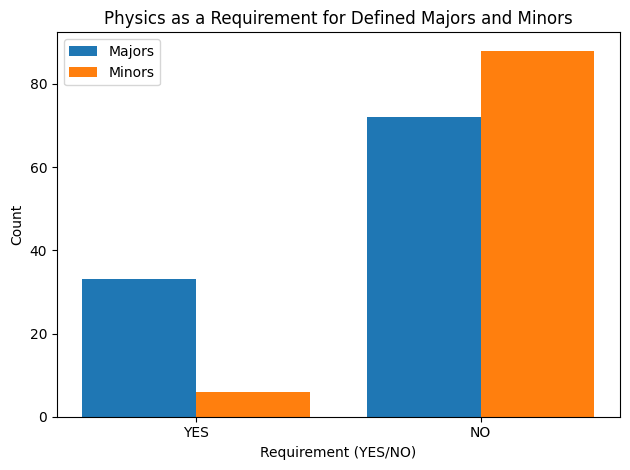

In [5]:
majors_count = majors_sql_df.groupby('requirement').size().reindex(['YES', 'NO'], fill_value=0)
minors_count = minors_sql_df.groupby('requirement').size().reindex(['YES', 'NO'], fill_value=0)

fig, ax = plt.subplots()

labels = ['YES', 'NO']
x = range(len(labels))

ax.bar(x, majors_count, width=0.4, label='Majors', align='center')
ax.bar([p + 0.4 for p in x], minors_count, width=0.4, label='Minors', align='center')

ax.set_xticks([p + 0.2 for p in x])
ax.set_xticklabels(labels)
ax.set_ylabel('Count')
ax.set_xlabel('Requirement (YES/NO)')
ax.set_title('Physics as a Requirement for Defined Majors and Minors')
ax.legend()

plt.tight_layout()
plt.show()

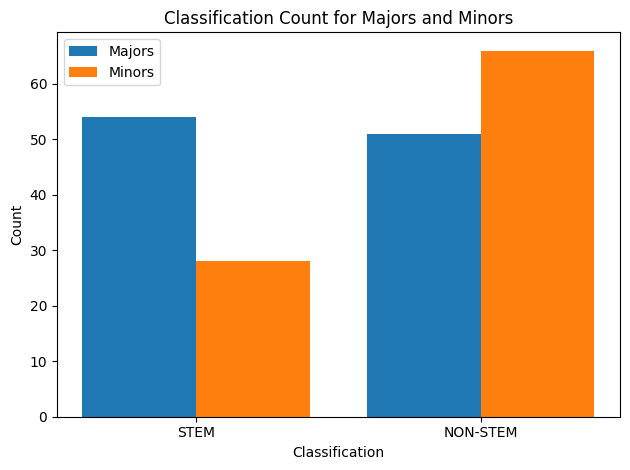

In [6]:
majors_classification_count = majors_sql_df.groupby('classification').size().reindex(['STEM', 'NON-STEM'], fill_value=0)
minors_classification_count = minors_sql_df.groupby('classification').size().reindex(['STEM', 'NON-STEM'], fill_value=0)

fig, ax = plt.subplots()

labels = ['STEM', 'NON-STEM']
x = range(len(labels))

ax.bar(x, majors_classification_count, width=0.4, label='Majors', align='center')
ax.bar([p + 0.4 for p in x], minors_classification_count, width=0.4, label='Minors', align='center')

ax.set_xticks([p + 0.2 for p in x])
ax.set_xticklabels(labels)
ax.set_ylabel('Count')
ax.set_xlabel('Classification')
ax.set_title('Classification Count for Majors and Minors')
ax.legend()

plt.tight_layout()
plt.show()

### Analyzing "Requirement"

In [8]:
query = """select t.ruid, t.major_1_id, t.major_1_name, m1.classification as m1_class, m1.requirement as m1_req, 
t.major_2_id, t.major_2_name, m2.classification as m2_class, m2.requirement as m2_req, 
t.minor_1_id, t.minor_1_name, m3.classification as mi1_class, m3.requirement as mi1_req, 
t.minor_2_id, t.minor_2_name, m4.classification as mi2_class, m4.requirement as mi2_req
from (select * from student_dist where major_1_id not in ('000', '001', '007')) as t
left join majors m1 on t.major_1_id = m1.major_id
left join majors m2 on t.major_2_id = m2.major_id
left join minors m3 on t.minor_1_id = m3.minor_id
left join minors m4 on t.minor_2_id = m4.minor_id;"""

exploratory_df = pd.read_sql_query(query, con=conn)


C:\Users\harsh\AppData\Local\Temp\ipykernel_28372\3887140999.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  exploratory_df = pd.read_sql_query(query, con=conn)


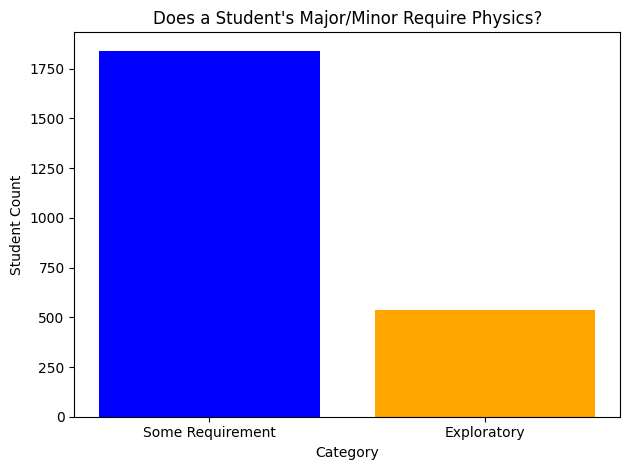

In [9]:
def categorize_row(row):
    if (row['m1_req'] in ['NO', None]) and (row['m2_req'] in ['NO', None]) and \
       (row['mi1_req'] in ['NO', None]) and (row['mi2_req'] in ['NO', None]):
        return 'Exploratory'
    else:
        return 'Some Requirement'

exploratory_df['category'] = exploratory_df.apply(categorize_row, axis=1)

category_counts = exploratory_df['category'].value_counts()

fig, ax = plt.subplots()

ax.bar(category_counts.index, category_counts.values, color=['blue', 'orange'])

ax.set_ylabel('Student Count')
ax.set_xlabel('Category')
ax.set_title('Does a Student\'s Major/Minor Require Physics?')

plt.tight_layout()
plt.show()

category
Major Requirement    1821
Exploratory           536
Major & Minor Req      14
Minor Requirement       6
Name: count, dtype: int64


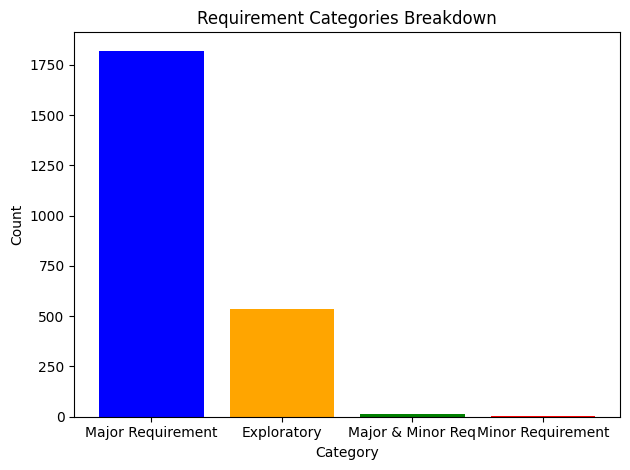

In [10]:
def categorize_row_detailed(row):
    major_req = row['m1_req'] == 'YES' or row['m2_req'] == 'YES'
    minor_req = row['mi1_req'] == 'YES' or row['mi2_req'] == 'YES'
    
    if major_req and minor_req:
        return 'Major & Minor Req'
    elif major_req:
        return 'Major Requirement'
    elif minor_req:
        return 'Minor Requirement'
    elif (row['m1_req'] in ['NO', None]) and (row['m2_req'] in ['NO', None]) and \
         (row['mi1_req'] in ['NO', None]) and (row['mi2_req'] in ['NO', None]):
        return 'Exploratory'
    else:
        return 'Exploratory'

exploratory_df['category'] = exploratory_df.apply(categorize_row_detailed, axis=1)

category_counts = exploratory_df['category'].value_counts()
print(category_counts)

fig, ax = plt.subplots()

ax.bar(category_counts.index, category_counts.values, color=['blue', 'orange', 'green', 'red'])

ax.set_ylabel('Count')
ax.set_xlabel('Category')
ax.set_title('Requirement Categories Breakdown')

plt.tight_layout()
plt.show()

### Stratifiying Majors

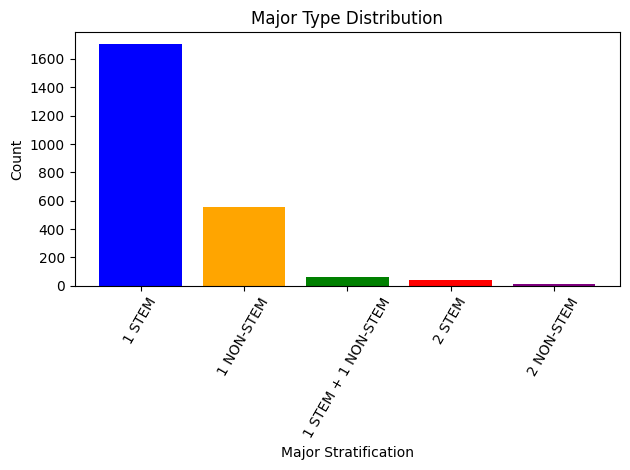

In [11]:
def classify_major(row):
    m1_class = row['m1_class']
    m2_class = row['m2_class']

    if m1_class == 'STEM' and m2_class == 'STEM':  # 2 STEM
        return '2 STEM'
    elif (m1_class == 'STEM' and m2_class == 'NON-STEM') or (m1_class == 'NON-STEM' and m2_class == 'STEM'):  # 1 STEM + 1 NON-STEM
        return '1 STEM + 1 NON-STEM'
    elif m1_class == 'NON-STEM' and m2_class == 'NON-STEM':  # 2 NON-STEM
        return '2 NON-STEM'
    elif m1_class == 'STEM' and m2_class is None:  # 1 STEM
        return '1 STEM'
    elif m1_class == 'NON-STEM' and m2_class is None:  # 1 NON-STEM
        return '1 NON-STEM'


exploratory_df['major_stratification'] = exploratory_df.apply(classify_major, axis=1)

major_stratification_counts = exploratory_df['major_stratification'].value_counts()

fig, ax = plt.subplots()

ax.bar(major_stratification_counts.index, major_stratification_counts.values, color=['blue', 'orange', 'green', 'red', 'purple'])

ax.set_ylabel('Count')
ax.set_xlabel('Major Stratification')
ax.set_title('Major Type Distribution')

plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

None STEM


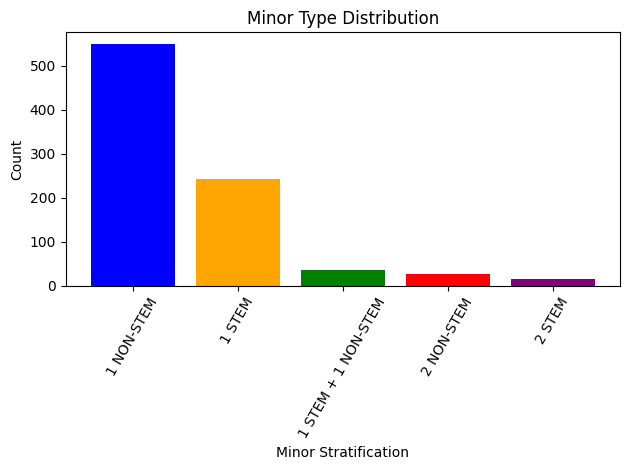

In [12]:
def classify_minor(row):
    mi1_class = row['mi1_class']
    mi2_class = row['mi2_class']

    if mi1_class == 'STEM' and mi2_class == 'STEM':  # 2 STEM
        return '2 STEM'
    elif (mi1_class == 'STEM' and mi2_class == 'NON-STEM') or (mi1_class == 'NON-STEM' and mi2_class == 'STEM'):  # 1 STEM + 1 NON-STEM
        return '1 STEM + 1 NON-STEM'
    elif mi1_class == 'NON-STEM' and mi2_class == 'NON-STEM':  # 2 NON-STEM
        return '2 NON-STEM'
    elif mi1_class == 'STEM' and mi2_class is None:  # 1 STEM
        return '1 STEM'
    elif mi1_class == 'NON-STEM' and mi2_class is None:  # 1 NON-STEM
        return '1 NON-STEM'
    elif mi1_class is None and mi2_class is None:
        pass
    else:
        print(mi1_class, mi2_class)



exploratory_df['minor_stratification'] = exploratory_df.apply(classify_minor, axis=1)

minor_stratification_counts = exploratory_df['minor_stratification'].value_counts()

fig, ax = plt.subplots()

ax.bar(minor_stratification_counts.index, minor_stratification_counts.values, color=['blue', 'orange', 'green', 'red', 'purple'])

ax.set_ylabel('Count')
ax.set_xlabel('Minor Stratification')
ax.set_title('Minor Type Distribution')

plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

STEM None None STEM
None None None None
combined_stratification
1 STEM Major                                                         1088
1 STEM Major + 1 NON-STEM Minor                                       406
1 NON-STEM Major                                                      326
1 STEM Major + 1 STEM Minor                                           152
1 NON-STEM Major + 1 NON-STEM Minor                                   133
1 NON-STEM Major + 1 STEM Minor                                        78
1 STEM Major + 1 NON-STEM Major                                        59
2 STEM Major                                                           43
1 STEM Major + 2 NON-STEM Minor                                        20
2 STEM Major + 1 STEM Minor + 1 NON-STEM Minor                         17
1 STEM Major + 2 STEM Minor                                            14
2 NON-STEM Major                                                       13
1 STEM Major + 1 STEM Minor + 1 NON-STEM Minor  

C:\Users\harsh\AppData\Local\Temp\ipykernel_28372\258181243.py:120: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


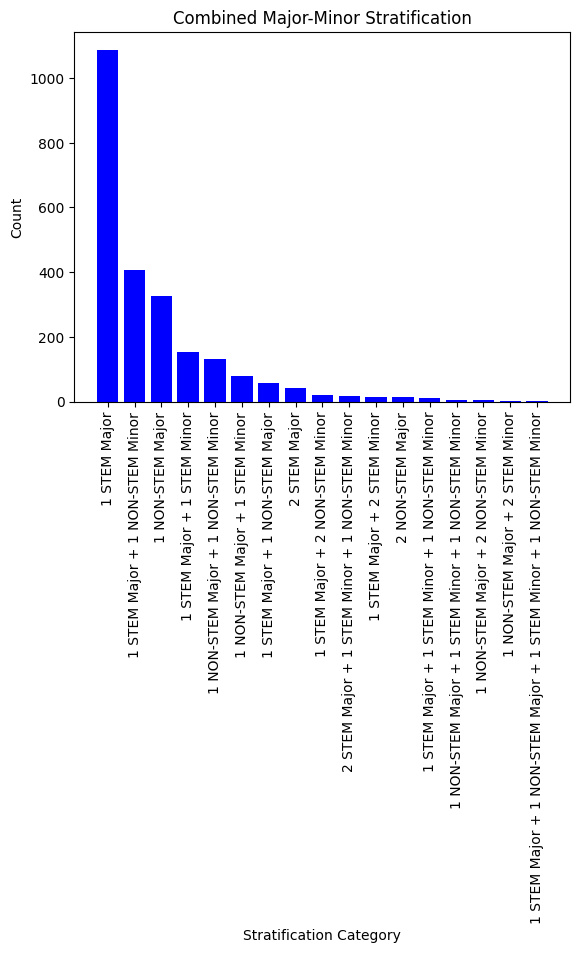

In [13]:
def classify_combined(row, exploratory=False):
    m1_class, m2_class = row['m1_class'], row['m2_class']
    mi1_class, mi2_class = row['mi1_class'], row['mi2_class']

    if exploratory:
        if not (row['m1_req'] in ['NO', None]) and (row['m2_req'] in ['NO', None]) and \
         (row['mi1_req'] in ['NO', None]) and (row['mi2_req'] in ['NO', None]):
            return
    
    if m1_class == 'STEM' and m2_class == 'STEM' and mi1_class == 'STEM' and mi2_class == 'STEM':
        return '2 STEM Major + 2 STEM Minor'
    
    elif m1_class == 'STEM' and m2_class == 'STEM' and (mi1_class == 'STEM' and mi2_class == 'NON-STEM') or (mi1_class == 'NON-STEM' and mi2_class == 'STEM'):
        return '2 STEM Major + 1 STEM Minor + 1 NON-STEM Minor'
    
    elif m1_class == 'STEM' and m2_class == 'STEM':
        return '2 STEM Major'
    
    elif m1_class == 'STEM' and m2_class == 'STEM' and mi1_class == 'STEM' and mi2_class is None:
        return '2 STEM Major + 1 STEM Minor'
    
    elif m1_class == 'STEM' and m2_class == 'STEM' and mi1_class == 'NON-STEM' and mi2_class is None:
        return '2 STEM Major + 1 NON-STEM Minor'

    elif m1_class == 'STEM' and m2_class == 'STEM' and mi1_class == 'NON-STEM' and mi2_class == 'NON-STEM':
        return '2 STEM Major + 2 NON-STEM Minor'
    
    

    elif m1_class == 'NON-STEM' and m2_class == 'NON-STEM' and mi1_class == 'STEM' and mi2_class == 'STEM':
        return '2 NON-STEM Major + 2 STEM Minor'
    
    elif m1_class == 'NON-STEM' and m2_class == 'NON-STEM' and (mi1_class == 'STEM' and mi2_class == 'NON-STEM') or (mi1_class == 'NON-STEM' and mi2_class == 'STEM'):
        return '2 NON-STEM Major + 1 STEM Minor + 1 NON-STEM Minor'
    
    elif m1_class == 'NON-STEM' and m2_class == 'NON-STEM':
        return '2 NON-STEM Major'
    
    elif m1_class == 'NON-STEM' and m2_class == 'NON-STEM' and mi1_class == 'STEM' and mi2_class is None:
        return '2 NON-STEM Major + 1 STEM Minor'
    
    elif m1_class == 'NON-STEM' and m2_class == 'NON-STEM' and mi1_class == 'NON-STEM' and mi2_class is None:
        return '2 NON-STEM Major + 1 NON-STEM Minor'

    elif m1_class == 'NON-STEM' and m2_class == 'NON-STEM' and mi1_class == 'NON-STEM' and mi2_class == 'NON-STEM':
        return '2 NON-STEM Major + 2 NON-STEM Minor'

    
    
    elif ((m1_class == 'STEM' and m2_class == 'NON-STEM') or (m1_class == 'NON-STEM' and m2_class == 'STEM')) \
        and mi1_class == 'STEM' and mi2_class == 'STEM':
        return '1 STEM Major + 1 NON-STEM Major + 2 STEM Minor'

    elif ((m1_class == 'STEM' and m2_class == 'NON-STEM') or (m1_class == 'NON-STEM' and m2_class == 'STEM')) \
         and  (mi1_class == 'STEM' and mi2_class == 'NON-STEM') or (mi1_class == 'NON-STEM' and mi2_class == 'STEM'):
        return '1 STEM Major + 1 NON-STEM Major + 1 STEM Minor + 1 NON-STEM Minor'    
    
    elif (m1_class == 'STEM' and m2_class == 'NON-STEM') or (m1_class == 'NON-STEM' and m2_class == 'STEM'):
        return '1 STEM Major + 1 NON-STEM Major'
    
    elif (m1_class == 'STEM' and m2_class == 'NON-STEM') or (m1_class == 'NON-STEM' and m2_class == 'STEM') and mi1_class == 'STEM' and mi2_class is None:
        return '1 STEM Major + 1 NON-STEM Major + 1 STEM Minor'
    
    elif (m1_class == 'STEM' and m2_class == 'NON-STEM') or (m1_class == 'NON-STEM' and m2_class == 'STEM') and mi1_class == 'NON-STEM' and mi2_class is None:
        return '1 STEM Major + 1 NON-STEM Major + 1 NON-STEM Minor'
    
    elif (m1_class == 'STEM' and m2_class == 'NON-STEM') or (m1_class == 'NON-STEM' and m2_class == 'STEM') and mi1_class == 'NON-STEM' and mi2_class == 'NON-STEM':
        return '1 STEM Major + 1 NON-STEM Major + 2 NON-STEM Minor'


    
    elif m1_class == 'STEM' and m2_class is None and mi1_class == 'STEM' and mi2_class == 'STEM':
        return '1 STEM Major + 2 STEM Minor'
    elif m1_class == 'STEM' and m2_class is None and (mi1_class == 'STEM' and mi2_class == 'NON-STEM') or (mi1_class == 'NON-STEM' and mi2_class == 'STEM'):
        return '1 STEM Major + 1 STEM Minor + 1 NON-STEM Minor'
    elif m1_class == 'STEM' and m2_class is None and mi1_class is None and mi2_class is None:
        return '1 STEM Major'
    elif m1_class == 'STEM' and m2_class is None and mi1_class == 'STEM' and mi2_class is None:
        return '1 STEM Major + 1 STEM Minor'
    elif m1_class == 'STEM' and m2_class is None and mi1_class == 'NON-STEM' and mi2_class is None:
        return '1 STEM Major + 1 NON-STEM Minor'
    elif m1_class == 'STEM' and m2_class is None and mi1_class == 'NON-STEM' and mi2_class == 'NON-STEM':
        return '1 STEM Major + 2 NON-STEM Minor'
    
    

    elif m1_class == 'NON-STEM' and m2_class is None and mi1_class == 'STEM' and mi2_class == 'STEM':
        return '1 NON-STEM Major + 2 STEM Minor'
    elif m1_class == 'NON-STEM' and m2_class is None and (mi1_class == 'STEM' and mi2_class == 'NON-STEM') or (mi1_class == 'NON-STEM' and mi2_class == 'STEM'):
        return '1 NON-STEM Major + 1 STEM Minor + 1 NON-STEM Minor'
    elif m1_class == 'NON-STEM' and m2_class is None and mi1_class is None and mi2_class is None:
        return '1 NON-STEM Major'
    elif m1_class == 'NON-STEM' and m2_class is None and mi1_class == 'STEM' and mi2_class is None:
        return '1 NON-STEM Major + 1 STEM Minor'
    elif m1_class == 'NON-STEM' and m2_class is None and mi1_class == 'NON-STEM' and mi2_class is None:
        return '1 NON-STEM Major + 1 NON-STEM Minor'
    elif m1_class == 'NON-STEM' and m2_class is None and mi1_class == 'NON-STEM' and mi2_class == 'NON-STEM':
        return '1 NON-STEM Major + 2 NON-STEM Minor'

    else:
        print(m1_class, m2_class, mi1_class, mi2_class)



exploratory_df['combined_stratification'] = exploratory_df.apply(classify_combined, axis=1)

combined_stratification_counts = exploratory_df['combined_stratification'].value_counts()
print(combined_stratification_counts)

fig, ax = plt.subplots()

ax.bar(combined_stratification_counts.index, combined_stratification_counts.values, color='blue')

ax.set_ylabel('Count')
ax.set_xlabel('Stratification Category')
ax.set_title('Combined Major-Minor Stratification')

plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

### Stratification for the "Exploratory" Population

STEM None None STEM
None None None None
combined_stratification_exp
1 NON-STEM Major                                      164
1 STEM Major                                          101
1 NON-STEM Major + 1 STEM Minor                        73
1 NON-STEM Major + 1 NON-STEM Minor                    70
1 STEM Major + 1 NON-STEM Minor                        48
1 STEM Major + 1 STEM Minor                            38
1 STEM Major + 1 NON-STEM Major                        28
2 STEM Major                                           21
1 STEM Major + 2 STEM Minor                             8
2 NON-STEM Major                                        8
2 STEM Major + 1 STEM Minor + 1 NON-STEM Minor          7
1 NON-STEM Major + 2 NON-STEM Minor                     5
1 STEM Major + 2 NON-STEM Minor                         4
1 NON-STEM Major + 1 STEM Minor + 1 NON-STEM Minor      4
1 STEM Major + 1 STEM Minor + 1 NON-STEM Minor          3
1 NON-STEM Major + 2 STEM Minor                         2
Name

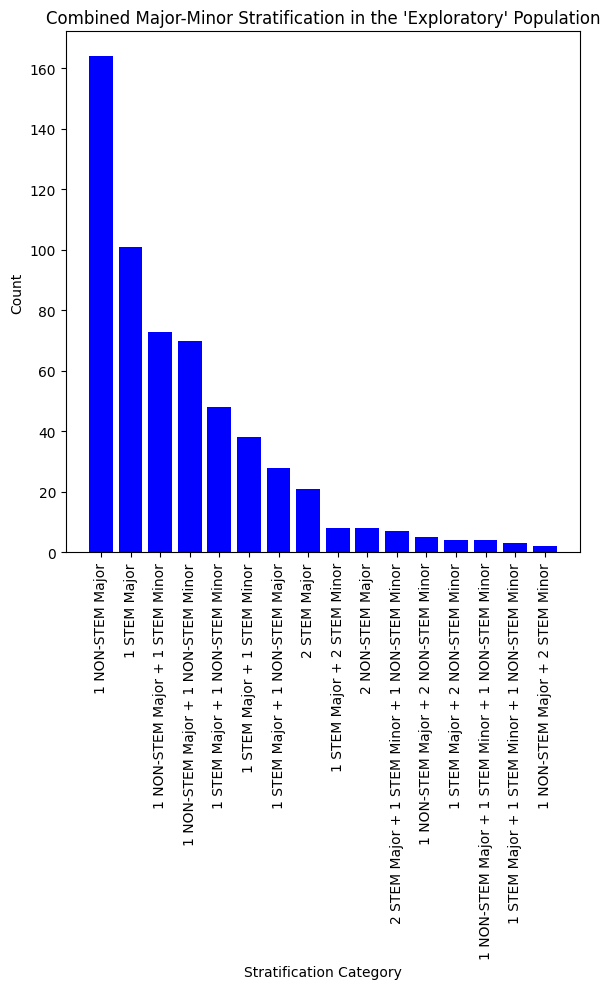

In [14]:
def drilled_exp_stratification(row):
    m1_class, m2_class = row['m1_class'], row['m2_class']
    mi1_class, mi2_class = row['mi1_class'], row['mi2_class']


    if not (row['m1_req'] in ['NO', None]) and (row['m2_req'] in ['NO', None]) and \
        (row['mi1_req'] in ['NO', None]) and (row['mi2_req'] in ['NO', None]):
        return 
    
    if m1_class == 'STEM' and m2_class == 'STEM' and mi1_class == 'STEM' and mi2_class == 'STEM':
        return '2 STEM Major + 2 STEM Minor'
    
    elif m1_class == 'STEM' and m2_class == 'STEM' and (mi1_class == 'STEM' and mi2_class == 'NON-STEM') or (mi1_class == 'NON-STEM' and mi2_class == 'STEM'):
        return '2 STEM Major + 1 STEM Minor + 1 NON-STEM Minor'
    
    elif m1_class == 'STEM' and m2_class == 'STEM':
        return '2 STEM Major'
    
    elif m1_class == 'STEM' and m2_class == 'STEM' and mi1_class == 'STEM' and mi2_class is None:
        return '2 STEM Major + 1 STEM Minor'
    
    elif m1_class == 'STEM' and m2_class == 'STEM' and mi1_class == 'NON-STEM' and mi2_class is None:
        return '2 STEM Major + 1 NON-STEM Minor'

    elif m1_class == 'STEM' and m2_class == 'STEM' and mi1_class == 'NON-STEM' and mi2_class == 'NON-STEM':
        return '2 STEM Major + 2 NON-STEM Minor'
    
    

    elif m1_class == 'NON-STEM' and m2_class == 'NON-STEM' and mi1_class == 'STEM' and mi2_class == 'STEM':
        return '2 NON-STEM Major + 2 STEM Minor'
    
    elif m1_class == 'NON-STEM' and m2_class == 'NON-STEM' and (mi1_class == 'STEM' and mi2_class == 'NON-STEM') or (mi1_class == 'NON-STEM' and mi2_class == 'STEM'):
        return '2 NON-STEM Major + 1 STEM Minor + 1 NON-STEM Minor'
    
    elif m1_class == 'NON-STEM' and m2_class == 'NON-STEM':
        return '2 NON-STEM Major'
    
    elif m1_class == 'NON-STEM' and m2_class == 'NON-STEM' and mi1_class == 'STEM' and mi2_class is None:
        return '2 NON-STEM Major + 1 STEM Minor'
    
    elif m1_class == 'NON-STEM' and m2_class == 'NON-STEM' and mi1_class == 'NON-STEM' and mi2_class is None:
        return '2 NON-STEM Major + 1 NON-STEM Minor'

    elif m1_class == 'NON-STEM' and m2_class == 'NON-STEM' and mi1_class == 'NON-STEM' and mi2_class == 'NON-STEM':
        return '2 NON-STEM Major + 2 NON-STEM Minor'

    
    
    elif ((m1_class == 'STEM' and m2_class == 'NON-STEM') or (m1_class == 'NON-STEM' and m2_class == 'STEM')) \
        and mi1_class == 'STEM' and mi2_class == 'STEM':
        return '1 STEM Major + 1 NON-STEM Major + 2 STEM Minor'

    elif ((m1_class == 'STEM' and m2_class == 'NON-STEM') or (m1_class == 'NON-STEM' and m2_class == 'STEM')) \
         and  (mi1_class == 'STEM' and mi2_class == 'NON-STEM') or (mi1_class == 'NON-STEM' and mi2_class == 'STEM'):
        return '1 STEM Major + 1 NON-STEM Major + 1 STEM Minor + 1 NON-STEM Minor'    
    
    elif (m1_class == 'STEM' and m2_class == 'NON-STEM') or (m1_class == 'NON-STEM' and m2_class == 'STEM'):
        return '1 STEM Major + 1 NON-STEM Major'
    
    elif (m1_class == 'STEM' and m2_class == 'NON-STEM') or (m1_class == 'NON-STEM' and m2_class == 'STEM') and mi1_class == 'STEM' and mi2_class is None:
        return '1 STEM Major + 1 NON-STEM Major + 1 STEM Minor'
    
    elif (m1_class == 'STEM' and m2_class == 'NON-STEM') or (m1_class == 'NON-STEM' and m2_class == 'STEM') and mi1_class == 'NON-STEM' and mi2_class is None:
        return '1 STEM Major + 1 NON-STEM Major + 1 NON-STEM Minor'
    
    elif (m1_class == 'STEM' and m2_class == 'NON-STEM') or (m1_class == 'NON-STEM' and m2_class == 'STEM') and mi1_class == 'NON-STEM' and mi2_class == 'NON-STEM':
        return '1 STEM Major + 1 NON-STEM Major + 2 NON-STEM Minor'


    
    elif m1_class == 'STEM' and m2_class is None and mi1_class == 'STEM' and mi2_class == 'STEM':
        return '1 STEM Major + 2 STEM Minor'
    elif m1_class == 'STEM' and m2_class is None and (mi1_class == 'STEM' and mi2_class == 'NON-STEM') or (mi1_class == 'NON-STEM' and mi2_class == 'STEM'):
        return '1 STEM Major + 1 STEM Minor + 1 NON-STEM Minor'
    elif m1_class == 'STEM' and m2_class is None and mi1_class is None and mi2_class is None:
        return '1 STEM Major'
    elif m1_class == 'STEM' and m2_class is None and mi1_class == 'STEM' and mi2_class is None:
        return '1 STEM Major + 1 STEM Minor'
    elif m1_class == 'STEM' and m2_class is None and mi1_class == 'NON-STEM' and mi2_class is None:
        return '1 STEM Major + 1 NON-STEM Minor'
    elif m1_class == 'STEM' and m2_class is None and mi1_class == 'NON-STEM' and mi2_class == 'NON-STEM':
        return '1 STEM Major + 2 NON-STEM Minor'
    
    

    elif m1_class == 'NON-STEM' and m2_class is None and mi1_class == 'STEM' and mi2_class == 'STEM':
        return '1 NON-STEM Major + 2 STEM Minor'
    elif m1_class == 'NON-STEM' and m2_class is None and (mi1_class == 'STEM' and mi2_class == 'NON-STEM') or (mi1_class == 'NON-STEM' and mi2_class == 'STEM'):
        return '1 NON-STEM Major + 1 STEM Minor + 1 NON-STEM Minor'
    elif m1_class == 'NON-STEM' and m2_class is None and mi1_class is None and mi2_class is None:
        return '1 NON-STEM Major'
    elif m1_class == 'NON-STEM' and m2_class is None and mi1_class == 'STEM' and mi2_class is None:
        return '1 NON-STEM Major + 1 STEM Minor'
    elif m1_class == 'NON-STEM' and m2_class is None and mi1_class == 'NON-STEM' and mi2_class is None:
        return '1 NON-STEM Major + 1 NON-STEM Minor'
    elif m1_class == 'NON-STEM' and m2_class is None and mi1_class == 'NON-STEM' and mi2_class == 'NON-STEM':
        return '1 NON-STEM Major + 2 NON-STEM Minor'

    else:
        print(m1_class, m2_class, mi1_class, mi2_class)

exploratory_df['combined_stratification_exp'] = exploratory_df.apply(drilled_exp_stratification, axis=1)

combined_stratification_exp_counts = exploratory_df['combined_stratification_exp'].value_counts()
print(combined_stratification_exp_counts)

fig, ax = plt.subplots(figsize=(6, 10))

ax.bar(combined_stratification_exp_counts.index, combined_stratification_exp_counts.values, color='blue')

ax.set_ylabel('Count')
ax.set_xlabel('Stratification Category')
ax.set_title('Combined Major-Minor Stratification in the \'Exploratory\' Population')

plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

### Major Changes, STEM Retention and STEM Attrition

In [5]:
majors_df = pd.read_sql_query("select * from majors", con = conn)
query = f'SELECT ruid, GROUP_CONCAT( major_id order by date_column separator \',\') AS major_pattern  \
    FROM courses_taken  \
    GROUP BY ruid'  
major_pattern_df = pd.read_sql_query(query, con = conn)

def get_unique_numbers(number_sequence):
    number_sequence = number_sequence.split(',')
    unique_numbers = []
    prev_num = None
    
    for num in number_sequence:
        if num != prev_num:
            # if prev_num is not None:

            unique_numbers.append(num)
            prev_num = num
    # return ', '.join(unique_numbers)
    return unique_numbers

def get_classifications(major_id_arr, majors_df):
    res = []
    for major_id in major_id_arr:
        res.append(majors_df.loc[major_id, 'classification'])
    return res

majors_df = majors_df.set_index('major_id')
major_pattern_df = major_pattern_df.set_index('ruid')

C:\Users\harsh\AppData\Local\Temp\ipykernel_22700\3108635846.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  majors_df = pd.read_sql_query("select * from majors", con = conn)
C:\Users\harsh\AppData\Local\Temp\ipykernel_22700\3108635846.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  major_pattern_df = pd.read_sql_query(query, con = conn)


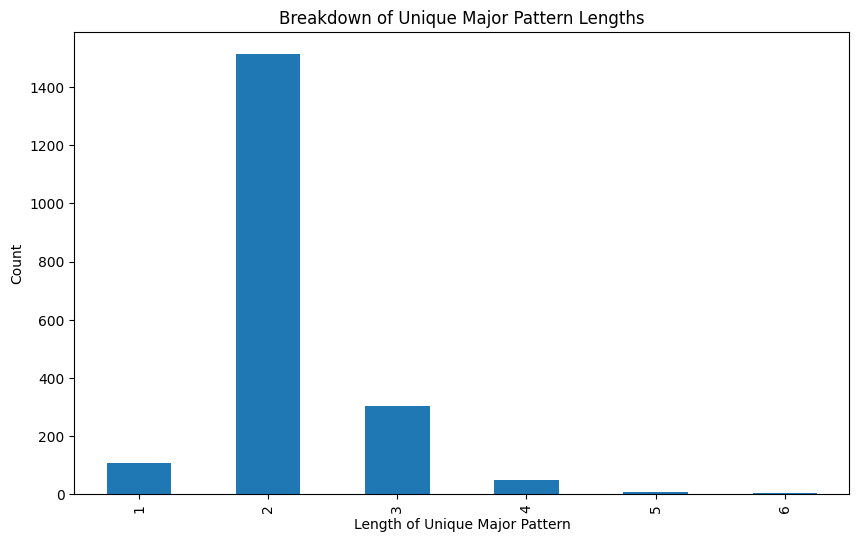

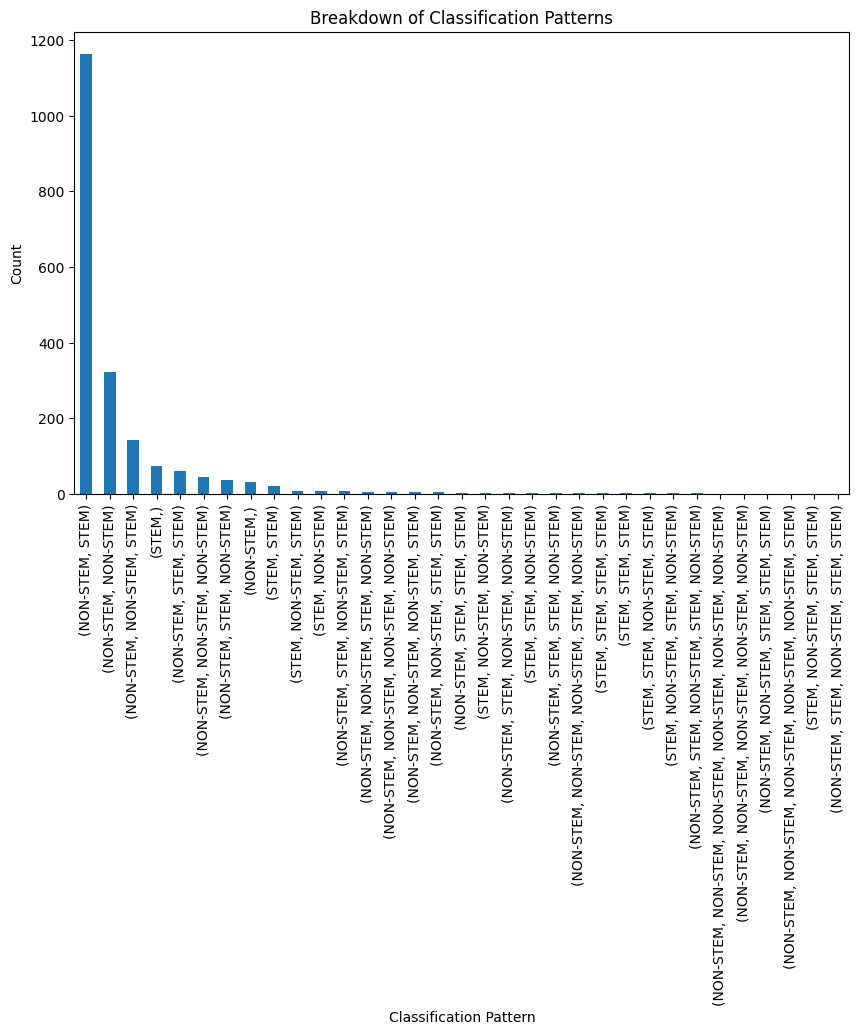

In [6]:
major_pattern_df['unique_major_pattern'] = major_pattern_df['major_pattern'].apply(get_unique_numbers)
major_pattern_df['classification_pattern'] = major_pattern_df['unique_major_pattern'].apply(lambda x: get_classifications(x, majors_df))


unique_major_pattern_counts = major_pattern_df['unique_major_pattern'].apply(len).value_counts().sort_index()

classification_pattern_counts = major_pattern_df['classification_pattern'].apply(tuple).value_counts()

plt.figure(figsize=(10, 6))
unique_major_pattern_counts.plot(kind='bar')
plt.title('Breakdown of Unique Major Pattern Lengths')
plt.xlabel('Length of Unique Major Pattern')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
classification_pattern_counts.plot(kind='bar')
plt.title('Breakdown of Classification Patterns')
plt.xlabel('Classification Pattern')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [8]:
introductory_major_codes = ['000', '001', '004', '006', '007', '008']

def strip_intro_major(arr):
    res = []
    if arr[0] in introductory_major_codes:
        if len(arr)>=1:
            res = arr[1:]
            for code in introductory_major_codes:
                if code in res:
                    res.remove(code)
    return res

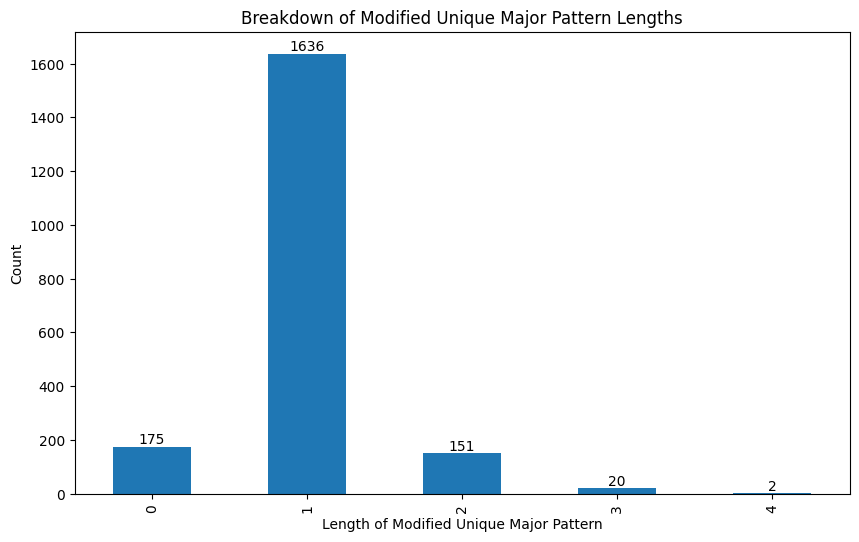

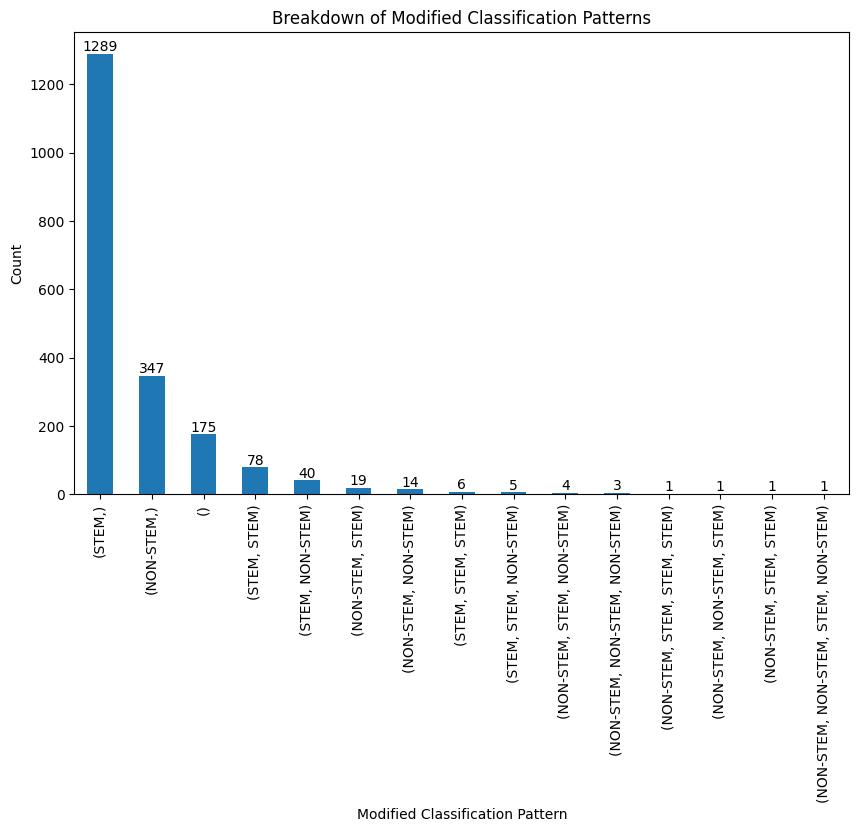

In [9]:
major_pattern_df['unique_major_pattern_mod'] = major_pattern_df['unique_major_pattern'].apply(lambda x: strip_intro_major(x))
major_pattern_df['classification_pattern_mod'] = major_pattern_df['unique_major_pattern_mod'].apply(lambda x: get_classifications(x, majors_df))

unique_major_pattern_counts = major_pattern_df['unique_major_pattern'].apply(len).value_counts().sort_index()
unique_major_pattern_mod_counts = major_pattern_df['unique_major_pattern_mod'].apply(len).value_counts().sort_index()

classification_pattern_counts = major_pattern_df['classification_pattern'].apply(tuple).value_counts()
classification_pattern_mod_counts = major_pattern_df['classification_pattern_mod'].apply(tuple).value_counts()


plt.figure(figsize=(10, 6))
unique_major_pattern_mod_counts.plot(kind='bar')
plt.title('Breakdown of Modified Unique Major Pattern Lengths')
plt.xlabel('Length of Modified Unique Major Pattern')
plt.ylabel('Count')
for i, v in enumerate(unique_major_pattern_mod_counts.values):
    plt.text(i, v, str(v), horizontalalignment='center', verticalalignment='bottom')
plt.show()

plt.figure(figsize=(10, 6))
classification_pattern_mod_counts.plot(kind='bar')
plt.title('Breakdown of Modified Classification Patterns')
plt.xlabel('Modified Classification Pattern')
plt.ylabel('Count')
plt.xticks(rotation=90)
for i, v in enumerate(classification_pattern_mod_counts.values):
    plt.text(i, v, str(v), horizontalalignment='center', verticalalignment='bottom')
plt.show()

In [10]:
def get_major_name(major_id, majors_df):
    return majors_df.loc[major_id, 'major_name']

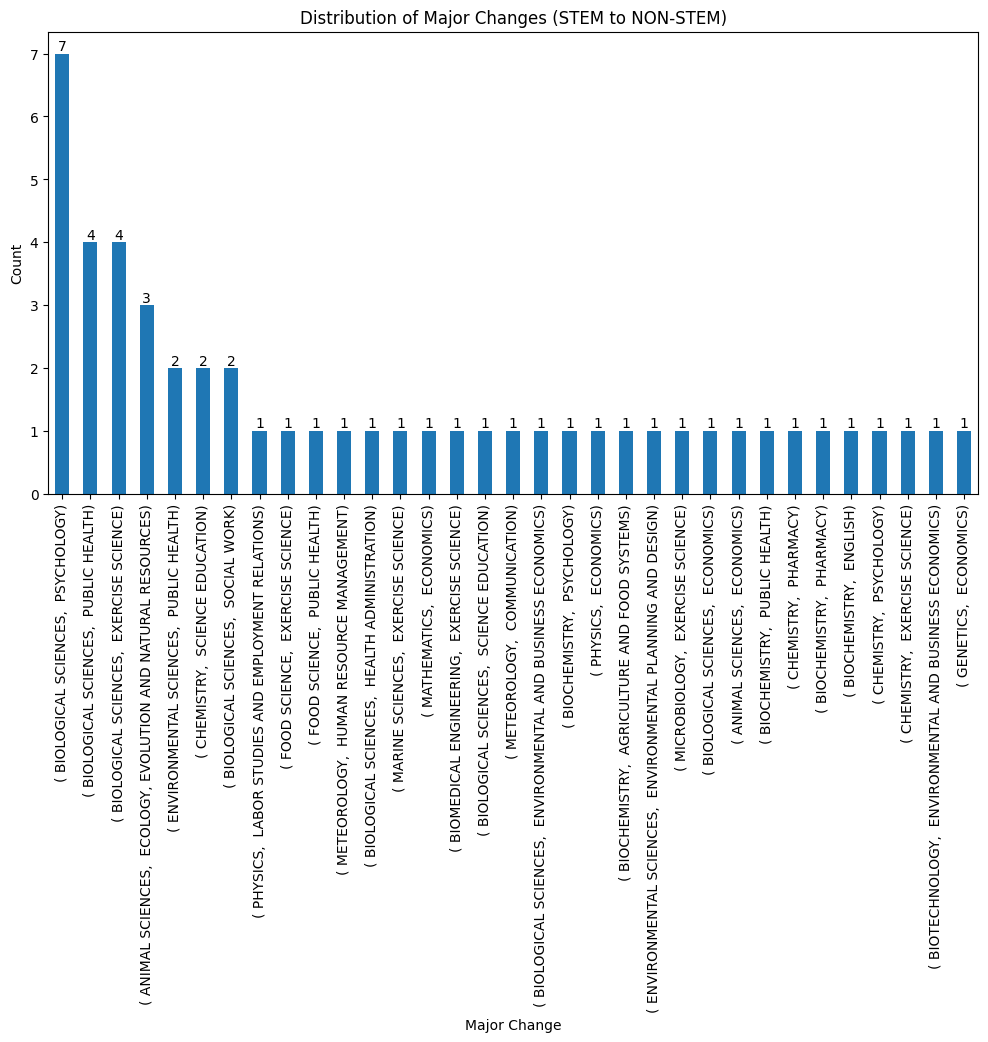

In [11]:
major_change_df = major_pattern_df[major_pattern_df['classification_pattern_mod'].apply(lambda x: any(x[i] == 'STEM' and x[i+1] in ['NON-STEM', 'INTERDISCIPLINARY'] for i in range(len(x)-1)))]

major_change_ruids = major_change_df.index.tolist()

major_changes = []
for _, row in major_change_df.iterrows():
    classification_pattern_mod = row['classification_pattern_mod']
    unique_major_pattern_mod = row['unique_major_pattern_mod']
    for i in range(len(classification_pattern_mod)-1):
        if classification_pattern_mod[i] == 'STEM' and classification_pattern_mod[i+1] in ['NON-STEM', 'INTERDISCIPLINARY']:
            stem_major = get_major_name(unique_major_pattern_mod[i], majors_df)
            new_major = get_major_name(unique_major_pattern_mod[i+1], majors_df)
            major_changes.append((stem_major, new_major))

major_change_counts = pd.Series(major_changes).value_counts()

plt.figure(figsize=(12, 6))
major_change_counts.plot(kind='bar')
plt.title('Distribution of Major Changes (STEM to NON-STEM)')
plt.xlabel('Major Change')
plt.ylabel('Count')
plt.xticks(rotation=90)
for i, v in enumerate(major_change_counts.values):
    plt.text(i, v, str(v), horizontalalignment='center', verticalalignment='bottom')
plt.show()


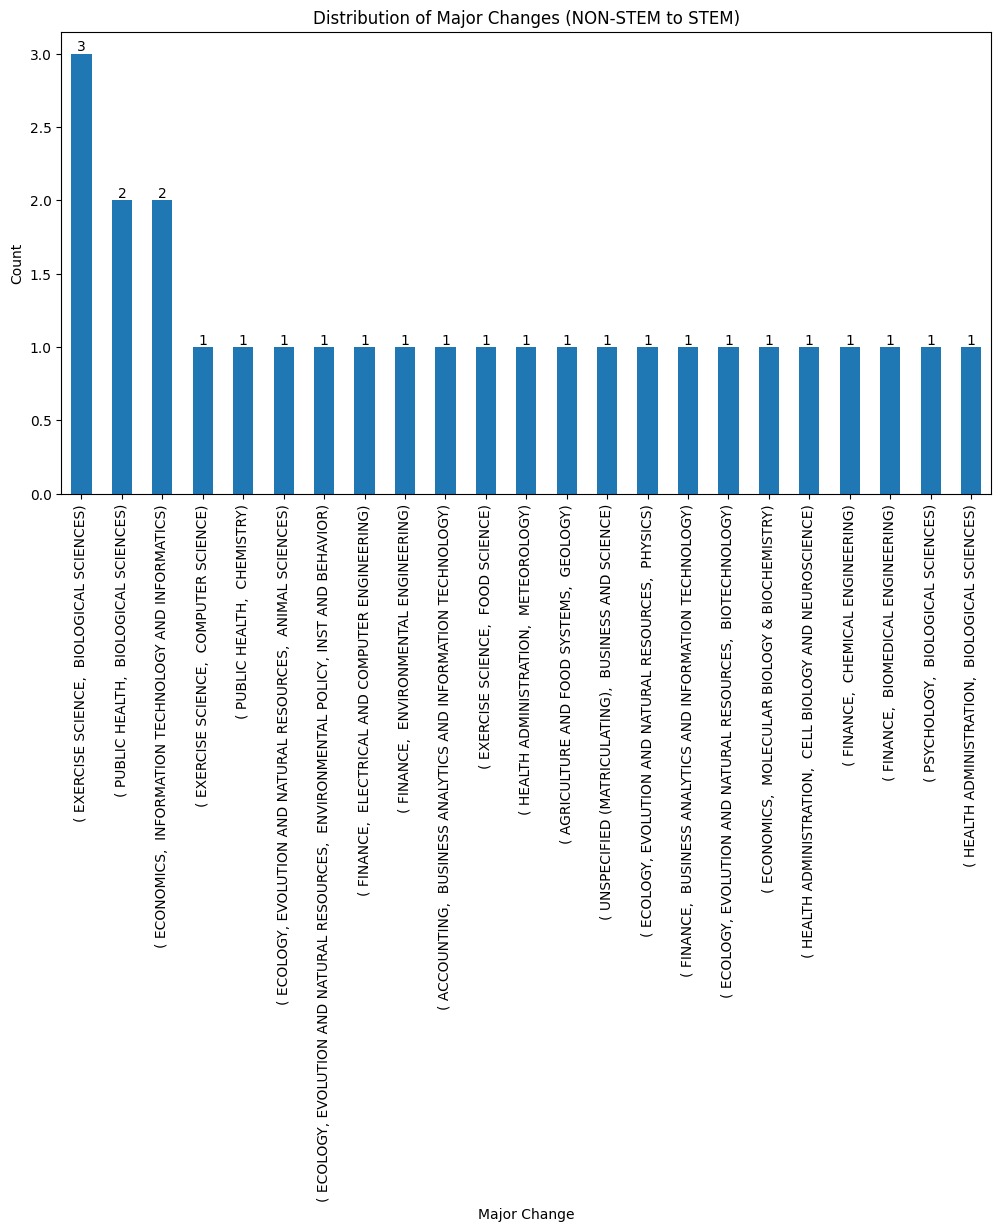

In [12]:
def has_non_stem_to_stem_change(classification_pattern):
    return any(classification_pattern[i] in ['NON-STEM', 'INTERDISCIPLINARY'] and
               classification_pattern[i+1] == 'STEM' for i in range(len(classification_pattern)-1))

non_stem_to_stem_df = major_pattern_df[major_pattern_df['classification_pattern_mod'].apply(has_non_stem_to_stem_change)]

non_stem_to_stem_ruids = non_stem_to_stem_df.index.tolist()

non_stem_to_stem_changes = []
for _, row in non_stem_to_stem_df.iterrows():
    classification_pattern_mod = row['classification_pattern_mod']
    unique_major_pattern_mod = row['unique_major_pattern_mod']
    for i in range(len(classification_pattern_mod)-1):
        if classification_pattern_mod[i] in ['NON-STEM', 'INTERDISCIPLINARY'] and classification_pattern_mod[i+1] == 'STEM':
            old_major = get_major_name(unique_major_pattern_mod[i], majors_df)
            new_major = get_major_name(unique_major_pattern_mod[i+1], majors_df)
            non_stem_to_stem_changes.append((old_major, new_major))

non_stem_to_stem_change_counts = pd.Series(non_stem_to_stem_changes).value_counts()

plt.figure(figsize=(12, 6))
non_stem_to_stem_change_counts.plot(kind='bar')
plt.title('Distribution of Major Changes (NON-STEM to STEM)')
plt.xlabel('Major Change')
plt.ylabel('Count')
plt.xticks(rotation=90)
for i, v in enumerate(non_stem_to_stem_change_counts.values):
    plt.text(i, v, str(v), horizontalalignment='center', verticalalignment='bottom')
plt.show()

### STEM Workload

In [13]:
prepost_analysis_df = pd.read_sql_query("select * from pre_post_analysis", con = conn)

C:\Users\harsh\AppData\Local\Temp\ipykernel_22700\4194046624.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prepost_analysis_df = pd.read_sql_query("select * from pre_post_analysis", con = conn)


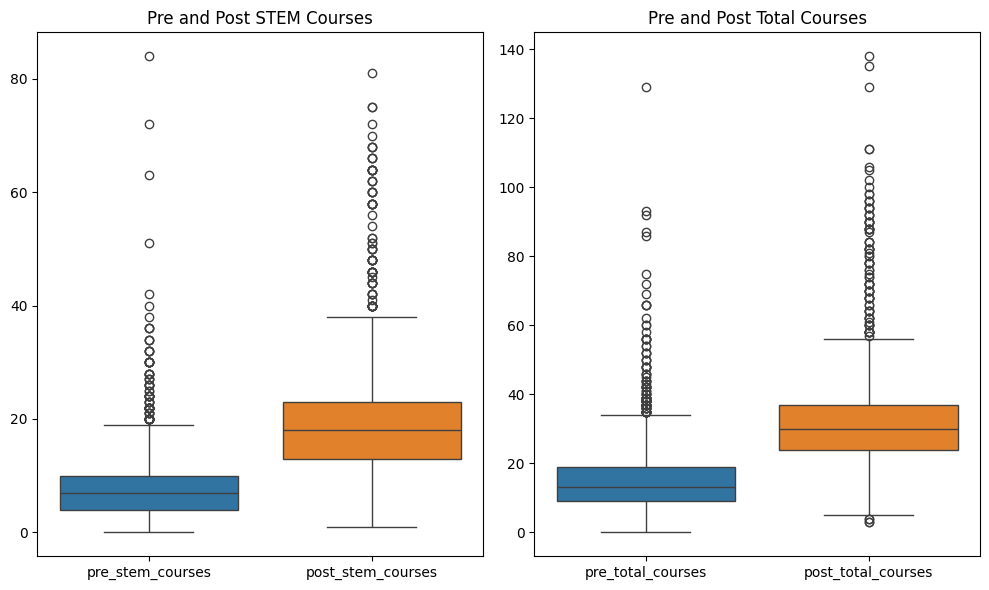

In [14]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=prepost_analysis_df[['pre_stem_courses', 'post_stem_courses']])
plt.title('Pre and Post STEM Courses')

plt.subplot(1, 2, 2)
sns.boxplot(data=prepost_analysis_df[['pre_total_courses', 'post_total_courses']])
plt.title('Pre and Post Total Courses')

plt.tight_layout()
plt.show()


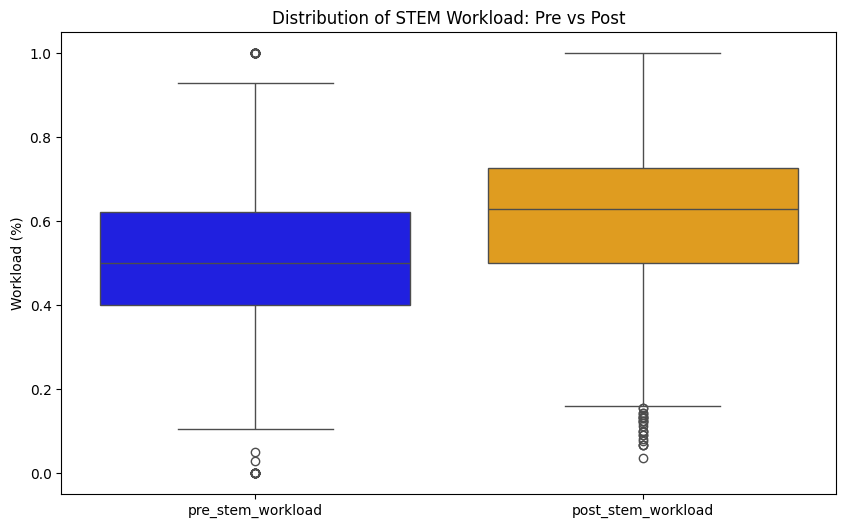

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=prepost_analysis_df[['pre_stem_workload', 'post_stem_workload']], palette=['blue', 'orange'])
plt.title('Distribution of STEM Workload: Pre vs Post')
plt.ylabel('Workload (%)')
plt.show()

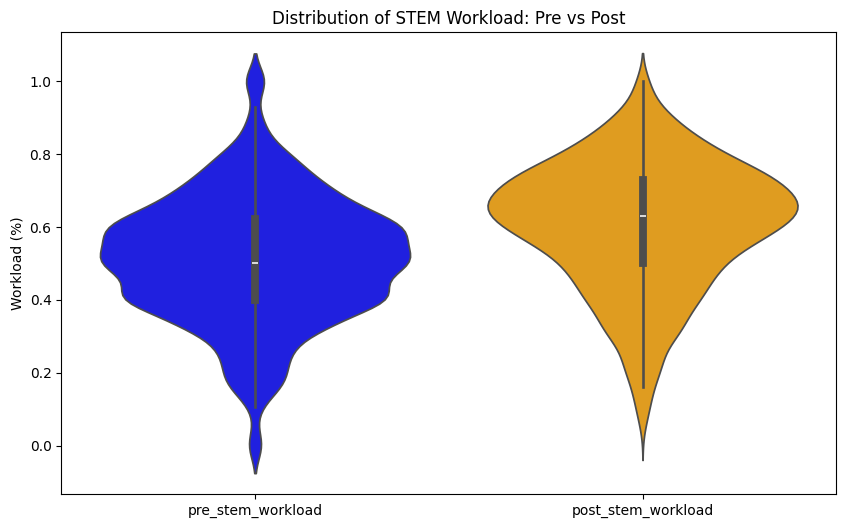

In [16]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=prepost_analysis_df[['pre_stem_workload', 'post_stem_workload']], palette=['blue', 'orange'])
plt.title('Distribution of STEM Workload: Pre vs Post')
plt.ylabel('Workload (%)')
plt.show()

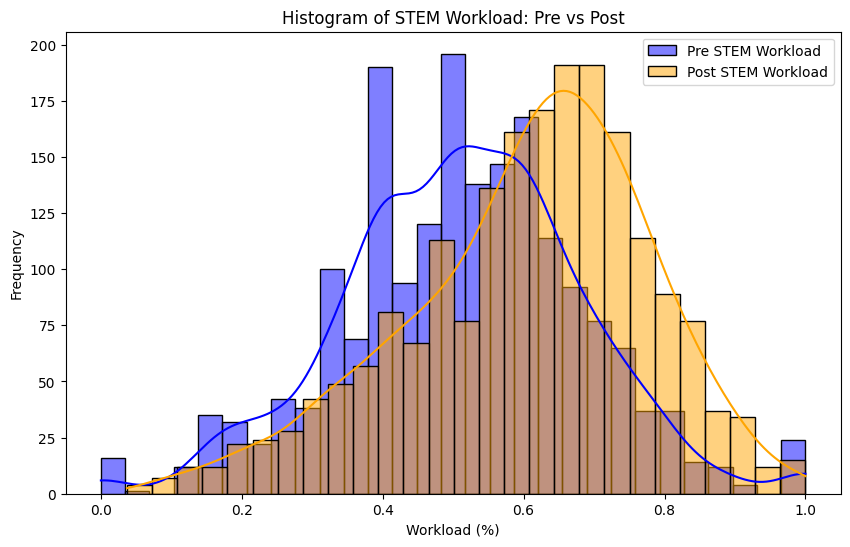

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(prepost_analysis_df['pre_stem_workload'], color='blue', label='Pre STEM Workload', kde=True)
sns.histplot(prepost_analysis_df['post_stem_workload'], color='orange', label='Post STEM Workload', kde=True)
plt.title('Histogram of STEM Workload: Pre vs Post')
plt.xlabel('Workload (%)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

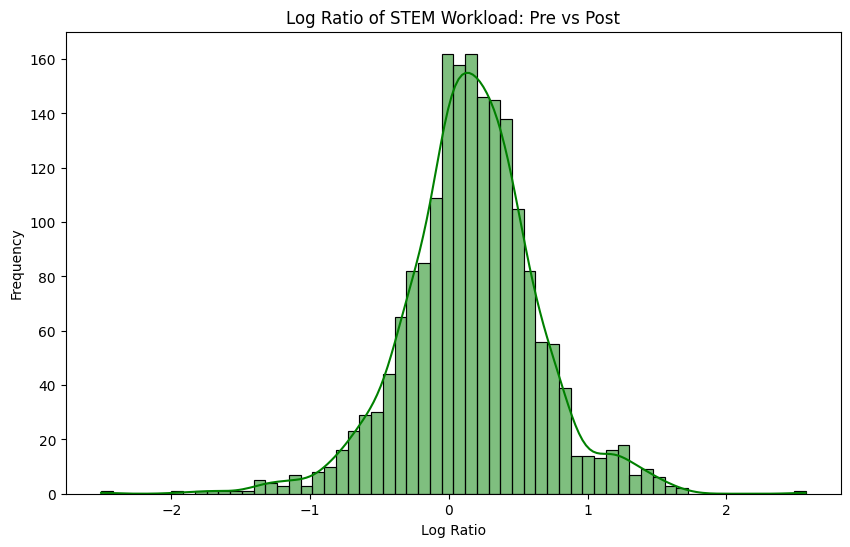

In [18]:
log_ratio = np.log(prepost_analysis_df['post_stem_workload'] / prepost_analysis_df['pre_stem_workload'])

prepost_analysis_df['log_ratio'] = log_ratio

# Visualization
plt.figure(figsize=(10, 6))
sns.histplot(log_ratio, kde=True, color='green')
plt.title('Log Ratio of STEM Workload: Pre vs Post')
plt.xlabel('Log Ratio')
plt.ylabel('Frequency')
plt.show()

### STEM Workload & Other Parameters

In [19]:
query = """select 
	p.ruid as ruid,
    p.pre_stem_courses,
    p.pre_total_courses,
    p.post_stem_courses,
    p.post_total_courses,
    p.pre_stem_workload,
    p.post_stem_workload,
    s.academic_year,
    s.semester_code_friendly,
    s.major_1_id,
    s.major_1_name,
    m1.classification as m1_class, 
    m1.requirement as m1_req,
    s.major_2_id,
    s.major_2_name,
    m2.classification as m2_class, 
    m2.requirement as m2_req,
    s.minor_1_id,
    s.minor_1_name,
    m3.classification as mi1_class, 
    m3.requirement as mi1_req, 
    s.minor_2_id,
    s.minor_2_name,
    m4.classification as mi2_class, 
    m4.requirement as mi2_req
from pre_post_analysis p
left join student_dist s on p.ruid = s.ruid
left join majors m1 on s.major_1_id = m1.major_id
left join majors m2 on s.major_2_id = m2.major_id
left join minors m3 on s.minor_1_id = m3.minor_id
left join minors m4 on s.minor_2_id = m4.minor_id;"""
workload_major_df = pd.read_sql_query(query, con = conn)
workload_major_df.describe()


C:\Users\harsh\AppData\Local\Temp\ipykernel_22700\486184359.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  workload_major_df = pd.read_sql_query(query, con = conn)


,pre_stem_courses,pre_total_courses,post_stem_courses,post_total_courses,pre_stem_workload,post_stem_workload,academic_year
count,2120.000000,2120.000000,2120.000000,2120.000000,2023.000000,2120.000000,2120.000000
mean,8.575472,16.531604,20.813208,34.816509,0.514365,0.605274,2022.136321
std,7.873466,13.208172,11.995989,18.025408,0.172418,0.174396,0.726237
min,0.000000,0.000000,1.000000,3.000000,0.000000,0.037040,2021.000000
25%,4.000000,9.000000,14.000000,24.000000,0.400000,0.500000,2022.000000
50%,7.000000,14.000000,19.000000,31.000000,0.500000,0.629630,2022.000000
75%,11.000000,20.250000,24.000000,39.000000,0.625000,0.727270,2023.000000
max,84.000000,129.000000,81.000000,138.000000,1.000000,1.000000,2024.000000


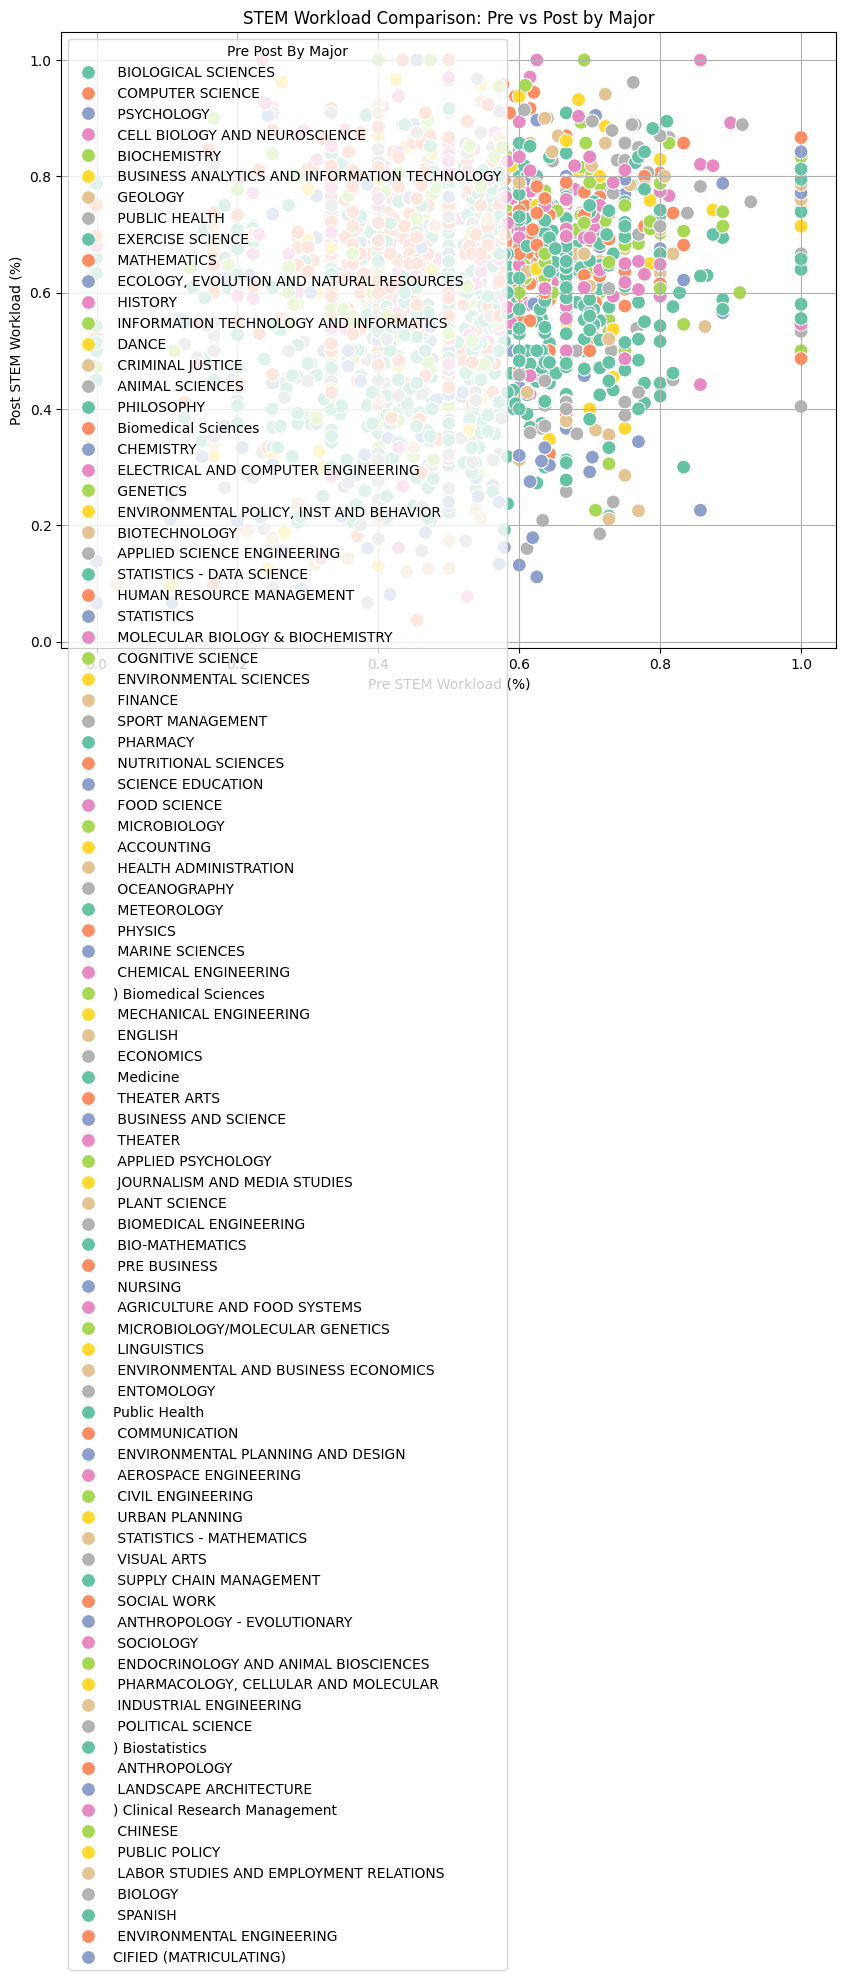

In [20]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=workload_major_df['pre_stem_workload'], y=workload_major_df['post_stem_workload'], hue=workload_major_df['major_1_name'], palette='Set2', s=100)

plt.title('STEM Workload Comparison: Pre vs Post by Major')
plt.xlabel('Pre STEM Workload (%)')
plt.ylabel('Post STEM Workload (%)')
plt.legend(title='Pre Post By Major')
plt.grid(True)
plt.show()

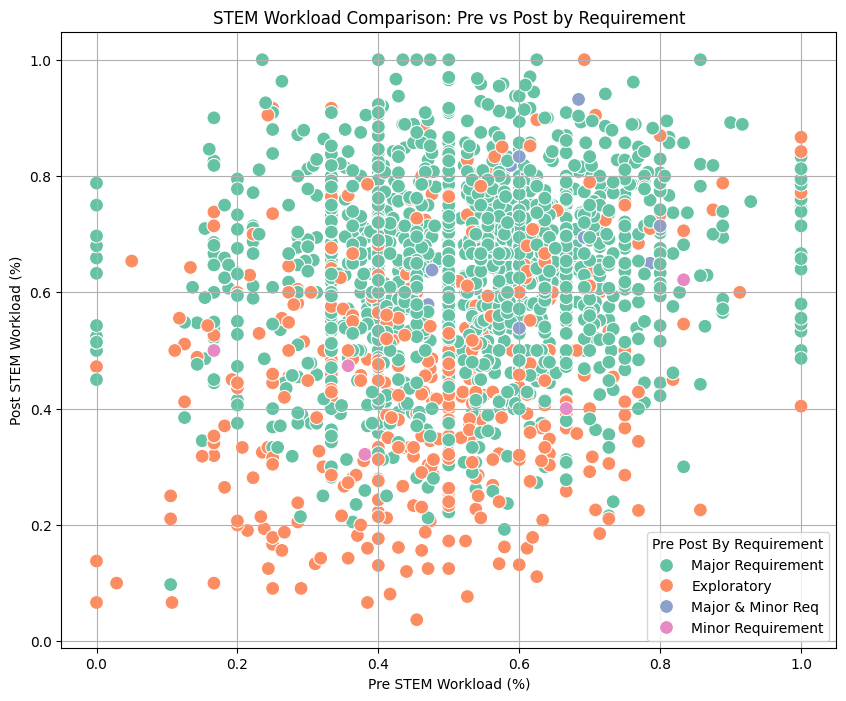

In [21]:
plt.figure(figsize=(10,8))
def categorize_exp(row):
    major_req = row['m1_req'] == 'YES' or row['m2_req'] == 'YES'
    minor_req = row['mi1_req'] == 'YES' or row['mi2_req'] == 'YES'
    
    if major_req and minor_req:
        return 'Major & Minor Req'
    elif major_req:
        return 'Major Requirement'
    elif minor_req:
        return 'Minor Requirement'
    elif (row['m1_req'] in ['NO', None]) and (row['m2_req'] in ['NO', None]) and \
         (row['mi1_req'] in ['NO', None]) and (row['mi2_req'] in ['NO', None]):
        return 'Exploratory'
    else:
        return 'Exploratory'
workload_major_df['exploratory_classification'] = workload_major_df.apply(categorize_exp, axis=1)
sns.scatterplot(x=workload_major_df['pre_stem_workload'], y=workload_major_df['post_stem_workload'], hue=workload_major_df['exploratory_classification'], palette='Set2', s=100)

plt.title('STEM Workload Comparison: Pre vs Post by Requirement')
plt.xlabel('Pre STEM Workload (%)')
plt.ylabel('Post STEM Workload (%)')
plt.legend(title='Pre Post By Requirement')
plt.grid(True)
plt.show()

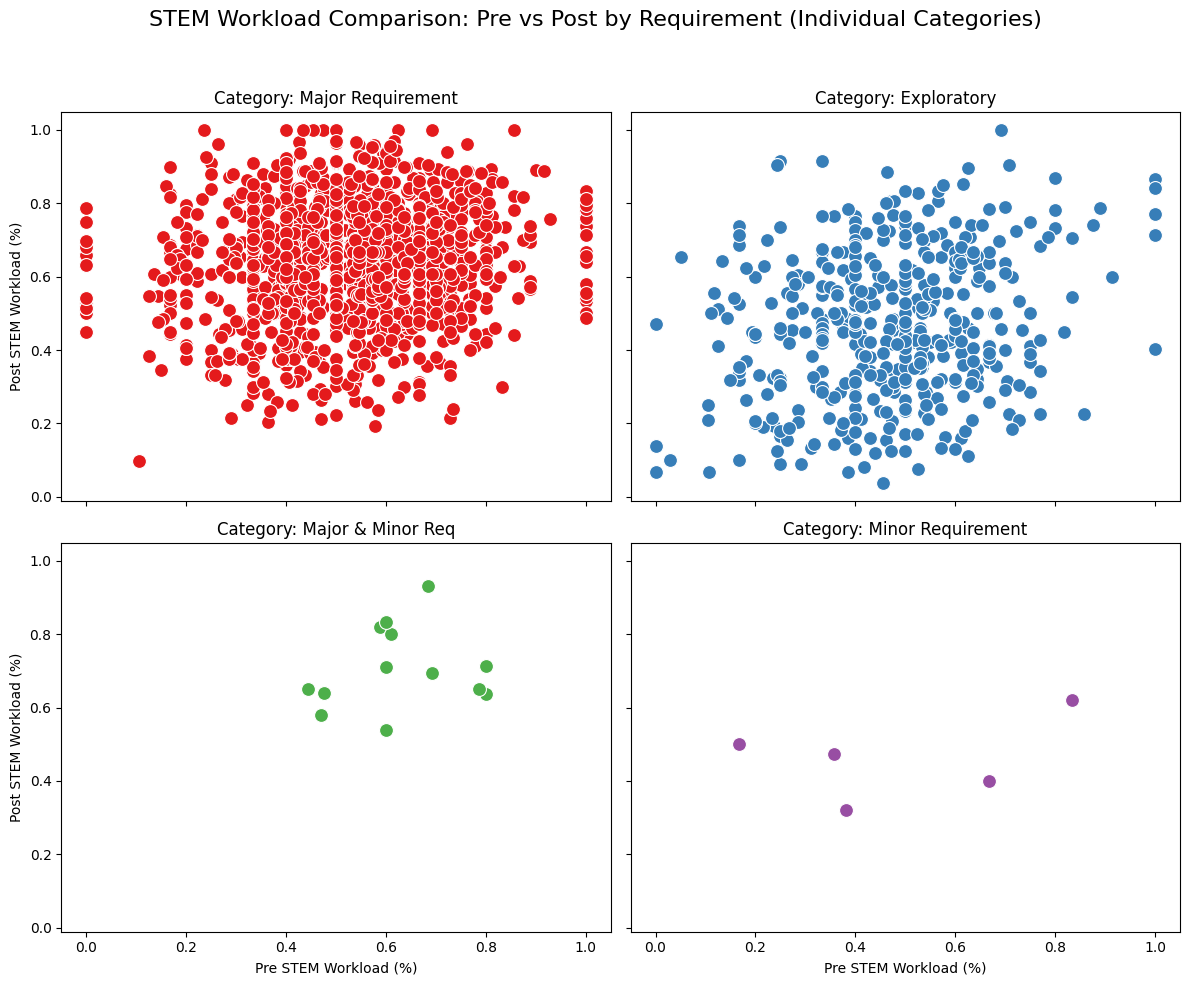

In [22]:
unique_categories = workload_major_df['exploratory_classification'].unique()

colors = sns.color_palette('Set1', len(unique_categories))

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

axes = axes.flatten()

for i, category in enumerate(unique_categories):
    filtered_df = workload_major_df[workload_major_df['exploratory_classification'] == category]
    
    sns.scatterplot(
        x=filtered_df['pre_stem_workload'], 
        y=filtered_df['post_stem_workload'], 
        ax=axes[i], 
        color=colors[i],  # Use a different color for each category
        s=100
    )
    
    axes[i].set_title(f'Category: {category}')
    axes[i].set_xlabel('Pre STEM Workload (%)')
    axes[i].set_ylabel('Post STEM Workload (%)')

plt.suptitle('STEM Workload Comparison: Pre vs Post by Requirement (Individual Categories)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
plt.show()

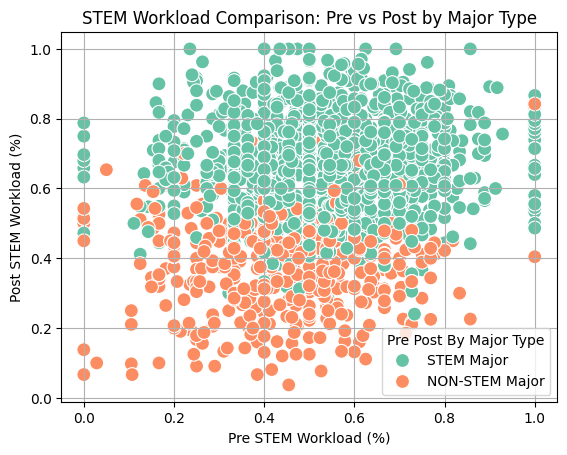

In [23]:
def categorize_stem_major(row):
    if row['m1_class'] == 'STEM' or row['m2_class'] == 'STEM':
        return "STEM Major"
    return "NON-STEM Major"

workload_major_df['stem_major'] = workload_major_df.apply(categorize_stem_major, axis=1)

sns.scatterplot(x=workload_major_df['pre_stem_workload'], y=workload_major_df['post_stem_workload'], hue=workload_major_df['stem_major'], palette='Set2', s=100)

plt.title('STEM Workload Comparison: Pre vs Post by Major Type')
plt.xlabel('Pre STEM Workload (%)')
plt.ylabel('Post STEM Workload (%)')
plt.legend(title='Pre Post By Major Type')
plt.grid(True)
plt.show()

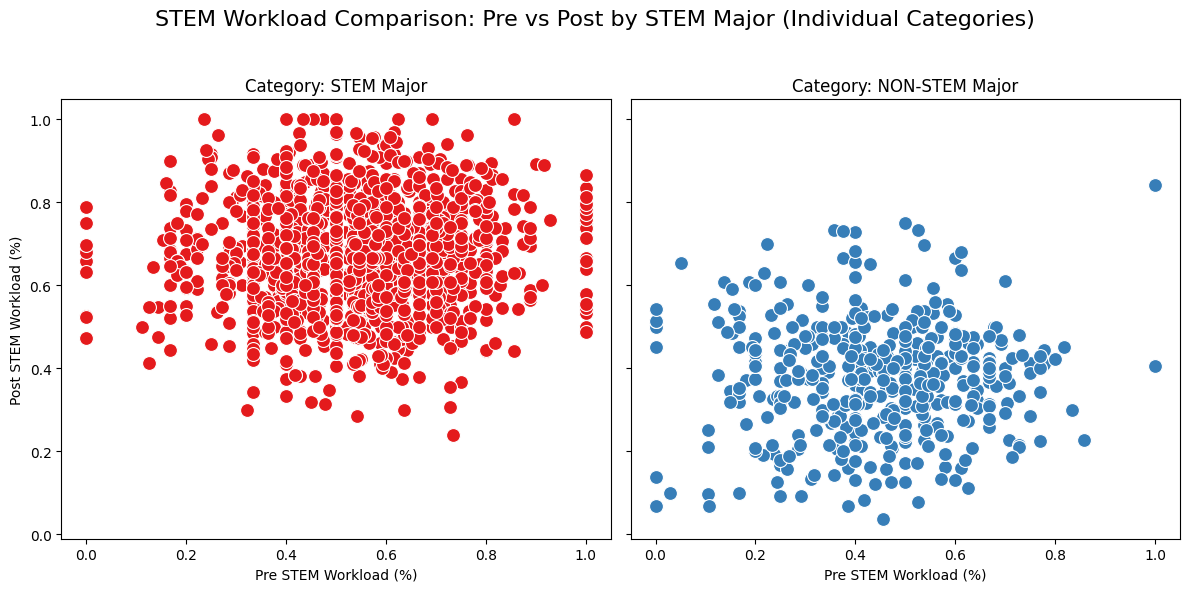

In [24]:
unique_categories = workload_major_df['stem_major'].unique()

colors = sns.color_palette('Set1', len(unique_categories))

fig, axes = plt.subplots(1,2, figsize=(12, 6), sharex=True, sharey=True)

axes = axes.flatten()

for i, category in enumerate(unique_categories):
    filtered_df = workload_major_df[workload_major_df['stem_major'] == category]
    
    sns.scatterplot(
        x=filtered_df['pre_stem_workload'], 
        y=filtered_df['post_stem_workload'], 
        ax=axes[i], 
        color=colors[i],  
        s=100
    )
    
    axes[i].set_title(f'Category: {category}')
    axes[i].set_xlabel('Pre STEM Workload (%)')
    axes[i].set_ylabel('Post STEM Workload (%)')

plt.suptitle('STEM Workload Comparison: Pre vs Post by STEM Major (Individual Categories)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
plt.show()

In [25]:
mega_merged_df = pd.merge(major_pattern_df, workload_major_df, on='ruid')
print(mega_merged_df.columns)

Index(['ruid', 'major_pattern', 'unique_major_pattern',
       'classification_pattern', 'unique_major_pattern_mod',
       'classification_pattern_mod', 'pre_stem_courses', 'pre_total_courses',
       'post_stem_courses', 'post_total_courses', 'pre_stem_workload',
       'post_stem_workload', 'academic_year', 'semester_code_friendly',
       'major_1_id', 'major_1_name', 'm1_class', 'm1_req', 'major_2_id',
       'major_2_name', 'm2_class', 'm2_req', 'minor_1_id', 'minor_1_name',
       'mi1_class', 'mi1_req', 'minor_2_id', 'minor_2_name', 'mi2_class',
       'mi2_req', 'exploratory_classification', 'stem_major'],
      dtype='object')


[2 1 0 3 4]


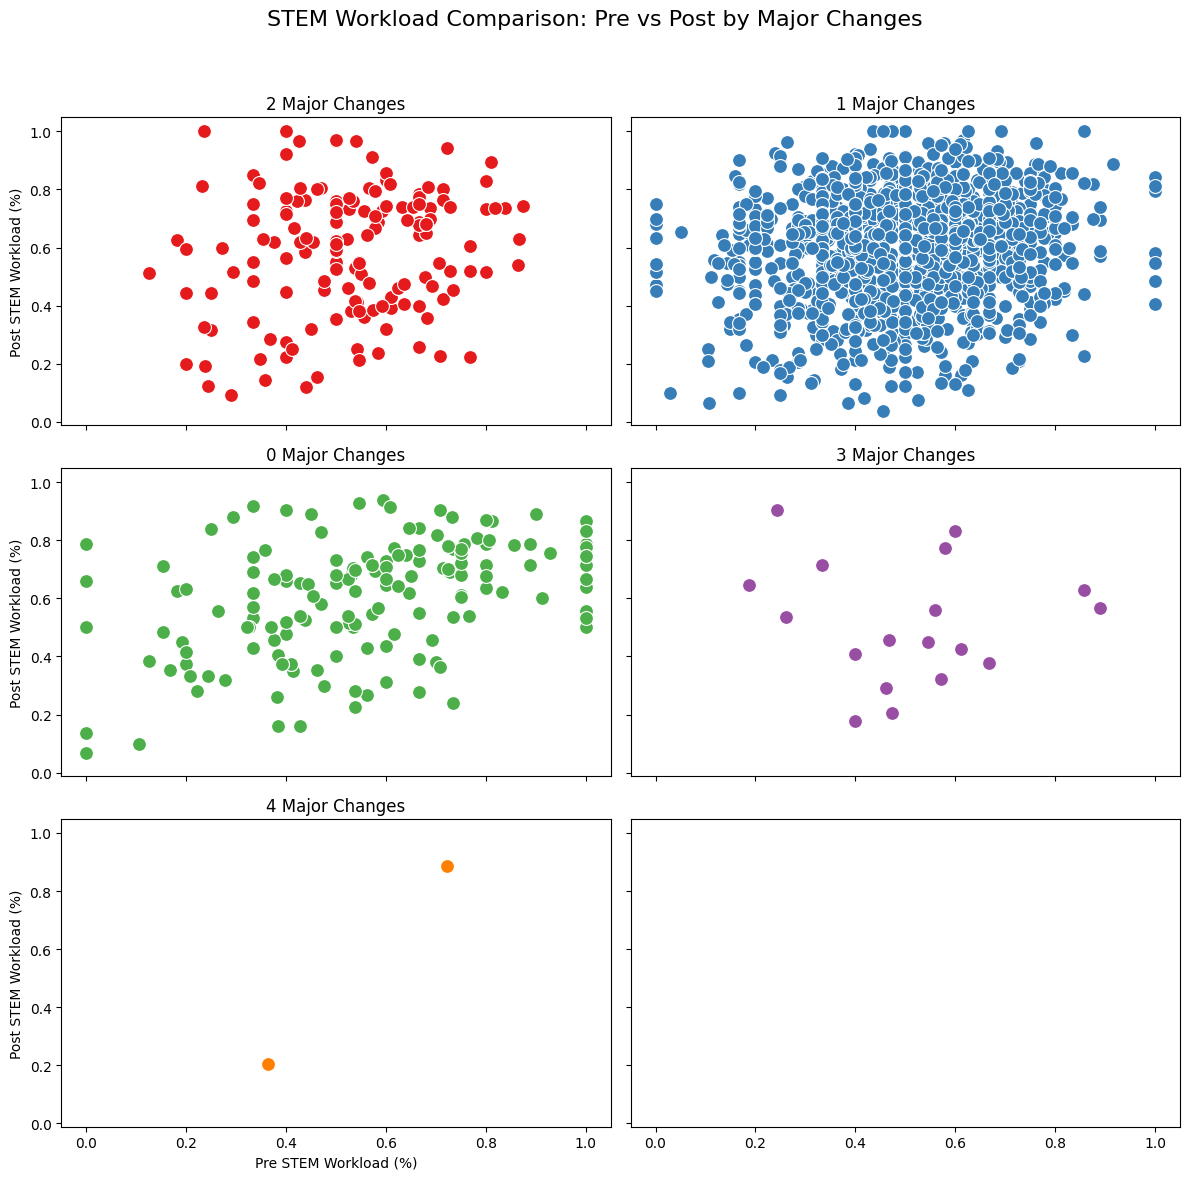

In [26]:
mega_merged_df['num_major_changes'] = mega_merged_df['unique_major_pattern_mod'].apply(len)

fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True)

axes = axes.flatten()
u = mega_merged_df['num_major_changes'].unique()
colors = sns.color_palette('Set1', len(u))


major_change_categories = mega_merged_df['num_major_changes'].unique()
print(major_change_categories)

for i, category in enumerate(major_change_categories):
    filtered_df = mega_merged_df[mega_merged_df['num_major_changes'] == category]
    
    sns.scatterplot(
        x=filtered_df['pre_stem_workload'], 
        y=filtered_df['post_stem_workload'], 
        ax=axes[i], 
        color=colors[i], 
        s=100
    )
    
    axes[i].set_title(f'{category} Major Changes')
    axes[i].set_xlabel('Pre STEM Workload (%)')
    axes[i].set_ylabel('Post STEM Workload (%)')

plt.suptitle('STEM Workload Comparison: Pre vs Post by Major Changes', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the space for the main title
plt.show()

C:\Users\harsh\AppData\Local\Temp\ipykernel_22700\2895856027.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  greater_than_one_df['transition_type'] = greater_than_one_df.apply(transition_type, axis=1)


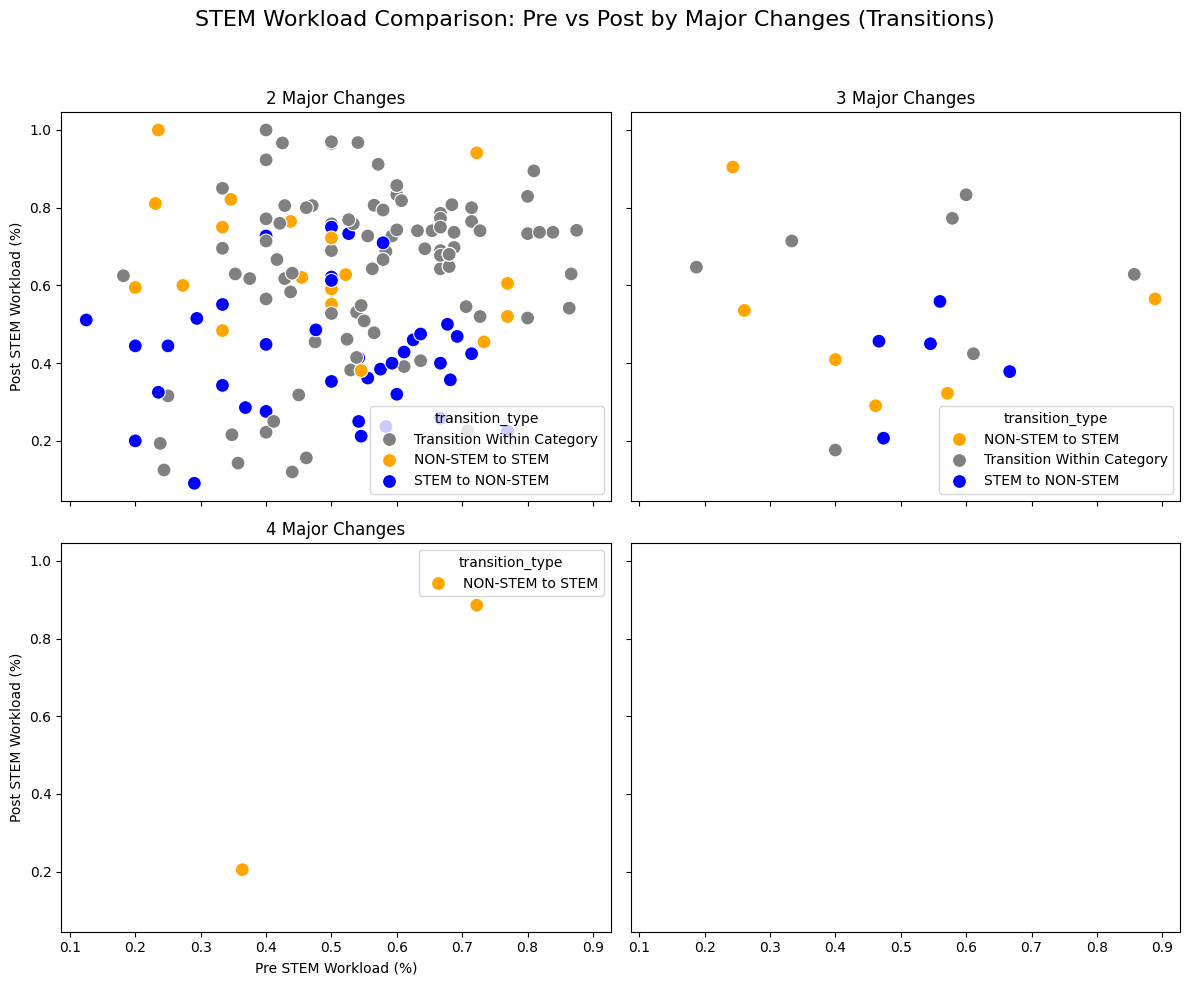

In [27]:
def has_stem_to_non_stem_change(classification_pattern):
    return any(classification_pattern[i] == 'STEM' and classification_pattern[i + 1] in ['NON-STEM', 'INTERDISCIPLINARY'] for i in range(len(classification_pattern) - 1))

non_stem_to_stem_df = mega_merged_df[mega_merged_df['classification_pattern_mod'].apply(has_non_stem_to_stem_change)]
stem_to_non_stem_df = mega_merged_df[mega_merged_df['classification_pattern_mod'].apply(has_stem_to_non_stem_change)]

greater_than_one_df = mega_merged_df[mega_merged_df['num_major_changes'] > 1]

def transition_type(row):
    if has_non_stem_to_stem_change(row['classification_pattern_mod']):
        return 'NON-STEM to STEM'
    elif has_stem_to_non_stem_change(row['classification_pattern_mod']):
        return 'STEM to NON-STEM'
    return 'Transition Within Category'

greater_than_one_df['transition_type'] = greater_than_one_df.apply(transition_type, axis=1)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

axes = axes.flatten()

major_change_categories = greater_than_one_df['num_major_changes'].unique()

for i, category in enumerate(major_change_categories):
    filtered_df = greater_than_one_df[greater_than_one_df['num_major_changes'] == category]
    
    sns.scatterplot(
        x=filtered_df['pre_stem_workload'], 
        y=filtered_df['post_stem_workload'], 
        ax=axes[i], 
        hue=filtered_df['transition_type'],
        palette={'NON-STEM to STEM': 'orange', 'STEM to NON-STEM': 'blue', 'Transition Within Category': 'gray'},
        s=100
    )
    
    axes[i].set_title(f'{category} Major Changes')
    axes[i].set_xlabel('Pre STEM Workload (%)')
    axes[i].set_ylabel('Post STEM Workload (%)')

plt.suptitle('STEM Workload Comparison: Pre vs Post by Major Changes (Transitions)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the space for the main title
plt.show()

### STEM Interest

In [28]:
query = """select * from stem_interest"""
stem_interest_df = pd.read_sql_query(query, con = conn)

C:\Users\harsh\AppData\Local\Temp\ipykernel_22700\4180390867.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stem_interest_df = pd.read_sql_query(query, con = conn)


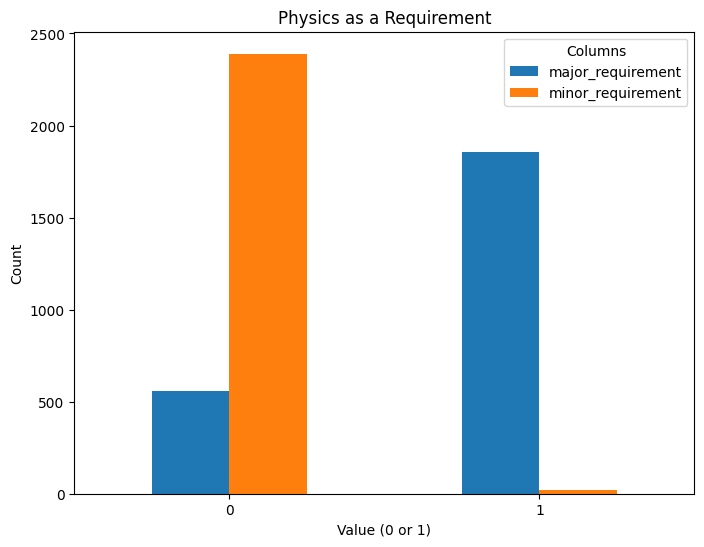

In [29]:
stem_interest_df.describe()

counts = stem_interest_df[['major_requirement', 'minor_requirement']].apply(pd.Series.value_counts)

counts.plot(kind='bar', figsize=(8, 6))
plt.title("Physics as a Requirement")
plt.xlabel("Value (0 or 1)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Columns")
plt.show()

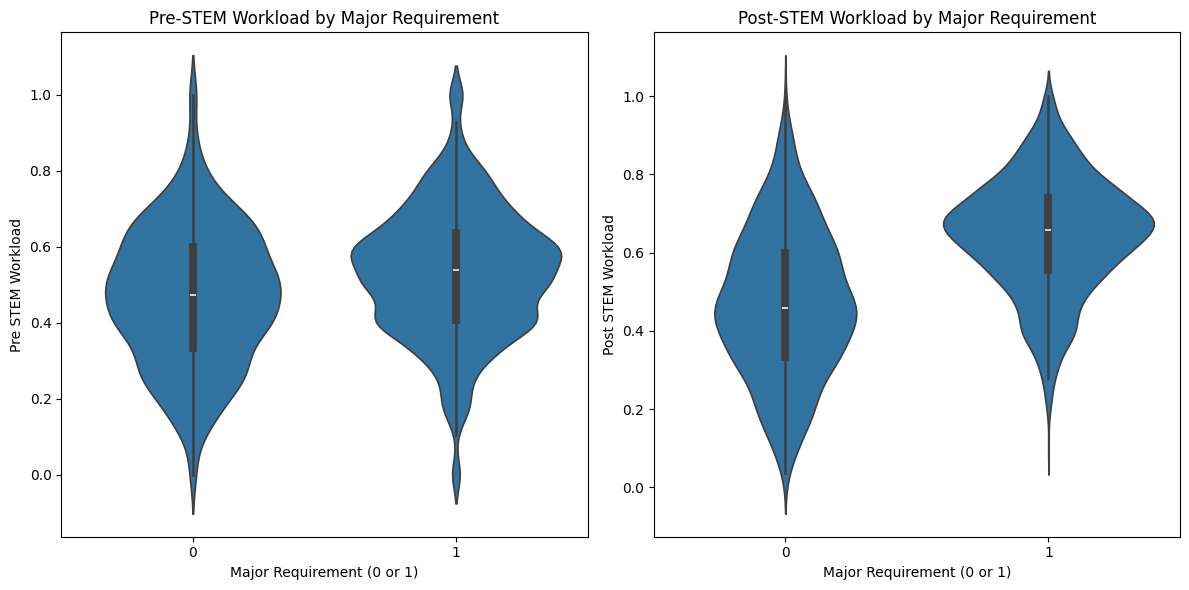

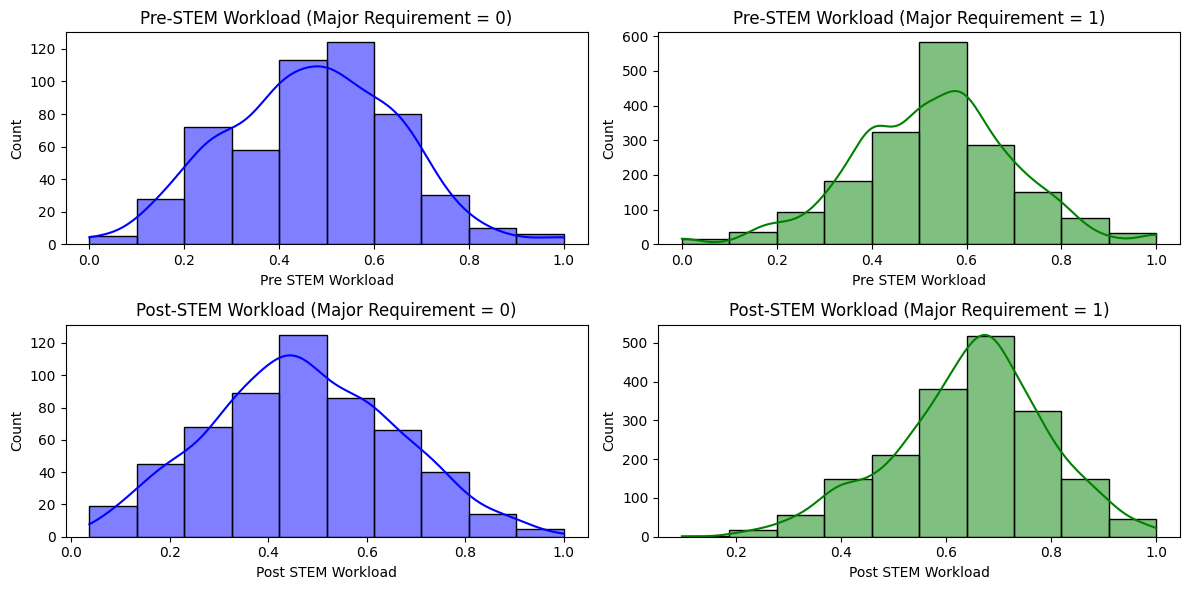

In [30]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.violinplot(x='major_requirement', y='pre_stem_workload', data=stem_interest_df)
plt.title('Pre-STEM Workload by Major Requirement')
plt.xlabel('Major Requirement (0 or 1)')
plt.ylabel('Pre STEM Workload')

plt.subplot(1, 2, 2)
sns.violinplot(x='major_requirement', y='post_stem_workload', data=stem_interest_df)
plt.title('Post-STEM Workload by Major Requirement')
plt.xlabel('Major Requirement (0 or 1)')
plt.ylabel('Post STEM Workload')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(stem_interest_df[stem_interest_df['major_requirement'] == 0]['pre_stem_workload'], kde=True, color='blue', bins=10)
plt.title('Pre-STEM Workload (Major Requirement = 0)')
plt.xlabel('Pre STEM Workload')

plt.subplot(2, 2, 2)
sns.histplot(stem_interest_df[stem_interest_df['major_requirement'] == 1]['pre_stem_workload'], kde=True, color='green', bins=10)
plt.title('Pre-STEM Workload (Major Requirement = 1)')
plt.xlabel('Pre STEM Workload')

plt.subplot(2, 2, 3)
sns.histplot(stem_interest_df[stem_interest_df['major_requirement'] == 0]['post_stem_workload'], kde=True, color='blue', bins=10)
plt.title('Post-STEM Workload (Major Requirement = 0)')
plt.xlabel('Post STEM Workload')

plt.subplot(2, 2, 4)
sns.histplot(stem_interest_df[stem_interest_df['major_requirement'] == 1]['post_stem_workload'], kde=True, color='green', bins=10)
plt.title('Post-STEM Workload (Major Requirement = 1)')
plt.xlabel('Post STEM Workload')

plt.tight_layout()
plt.show()